# TP2 - Predicción de series con Chronos

**Objetivo.** Pronosticar Ag Barometer AR, Ag Barometer USA e ICG con Chronos y contrastar resultados con TP1.

**Alcance.** Se implementa una partición train/validation/test (60%/20%/20%) para evaluar el modelo fundacional con mayor rigor, permitiendo ajuste de hiperparámetros en validación antes de la evaluación final en test.

## Datos y series

Se utilizan tres series limpias de `data/clean_data`:
- `agbarometer_cleaned.csv` — Argentina, frecuencia bimestral `2MS`, ~42 observaciones.
- `AgEconomyBarometer_cleaned.csv` — USA, frecuencia mensual `MS`, ~86 observaciones.
- `ICG_cleaned.csv` — UTDT, frecuencia mensual `MS`, ~264 observaciones.

**Criterios de preparación (alineados con TP1):**
- Normalización de fechas a `ds` y valores a `y`.
- Orden y deduplicación.
- Ag Barometer AR se re-muestrea a frecuencia bimestral (`2MS`), con **corrección manual** del desfase de pandemia 2020 (interpolación de marzo y mayo como promedio de vecinos, eliminación de abril — idéntico a TP1).
- Ag Barometer USA e ICG se re-muestrean a frecuencia mensual (`MS`).
- **Interpolación manual:** Si `asfreq()` introduce NaN (fechas sin dato), se rellenan calculando el promedio de los vecinos temporales más cercanos. NO se usa `.interpolate()` automático, replicando la filosofía de TP1 donde cada imputación es explícita y trazable.
- Se preserva la misma cantidad de observaciones que en TP1 (42, 86 y 264 respectivamente).

> **Nota didáctica:** A diferencia de TimeGPT (que recibe DataFrames con `ds`/`y`), Chronos trabaja con tensores de PyTorch. Sin embargo, mantenemos la convención `ds`/`y` en la preparación porque: (a) facilita reutilizar las mismas funciones de preparación, y (b) necesitamos las fechas para construir el índice temporal del pronóstico.

In [1]:
# Instalar dependencias si hace falta (solo la primera vez)
#uv pip -q install chronos-forecasting torch transformers accelerate

In [2]:
import logging
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use("seaborn-v0_8")
warnings.filterwarnings(
    "ignore",
    message="Could not infer format, so each element will be parsed individually.*",
    category=UserWarning,
 )
logging.getLogger("transformers").setLevel(logging.ERROR)

/Users/alejandro/Documents/Documentos - MacBook Air de Alejandro/Austral/Datos/AST/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = Path("../data/clean_data")

SERIES_CONFIG = {
    "ag_barometer_ar": {
        "file": "agbarometer_cleaned.csv",
        "date_col": "Bimestre",
        "value_col": "Ag Barometer",
        "train_frac": 0.6,  # 60% train
        "val_frac": 0.2,    # 20% validation
        "test_frac": 0.2,   # 20% test
    },
    "ag_barometer_usa": {
        "file": "AgEconomyBarometer_cleaned.csv",
        "date_col": ["Month", "Year"],
        "value_col": "Purdue/CME Ag Economy Barometer",
        "train_frac": 0.6,  # 60% train
        "val_frac": 0.2,    # 20% validation
        "test_frac": 0.2,   # 20% test
    },
    "icg_utdt": {
        "file": "ICG_cleaned.csv",
        "date_col": "date",
        "value_col": "value",
        "train_frac": 0.6,  # 60% train
        "val_frac": 0.2,    # 20% validation
        "test_frac": 0.2,   # 20% test
    },
}

HORIZON = 12  # periodos a pronosticar

MODEL_ID = "amazon/chronos-t5-base"

DEVICE = "cpu"
DTYPE = torch.float32

In [4]:
def _interpolar_manual(df):
    """
    Interpolación MANUAL de NaN introducidos por asfreq(), idéntica a la
    lógica de TP1: cada valor faltante se rellena con el promedio de los
    vecinos temporales no-NaN más cercanos (anterior y posterior).

    NO se usa .interpolate() automático para mantener control explícito
    sobre cada imputación y garantizar comparabilidad con TP1.
    """
    nans = df[df["y"].isna()]
    if nans.empty:
        return df

    print(f"  ⚙️  Interpolación manual: {len(nans)} fecha(s) faltante(s)")
    for idx in nans.index:
        # Vecino anterior no-NaN
        prev_vals = df.loc[:idx, "y"].dropna()
        # Vecino posterior no-NaN
        next_vals = df.loc[idx:, "y"].dropna()

        if not prev_vals.empty and not next_vals.empty:
            val = (prev_vals.iloc[-1] + next_vals.iloc[0]) / 2
            src = "promedio de vecinos"
        elif not prev_vals.empty:
            val = prev_vals.iloc[-1]
            src = "forward fill (sin vecino posterior)"
        elif not next_vals.empty:
            val = next_vals.iloc[0]
            src = "backward fill (sin vecino anterior)"
        else:
            continue

        df.loc[idx, "y"] = val
        print(f"    {idx.strftime('%Y-%m-%d')}: {val:.2f} ({src})")

    return df


def prepare_series(config_key, config):
    """Prepara y limpia una serie temporal aplicando correcciones manuales e interpolación."""
    path = DATA_DIR / config["file"]
    df = pd.read_csv(path)
    date_col = config["date_col"]
    value_col = config["value_col"]

    if isinstance(date_col, list):
        month_raw = df[date_col[0]].astype(str).str.strip()
        year_num = pd.to_numeric(df[date_col[1]], errors="coerce")

        month_map = {
            "january": 1, "february": 2, "march": 3, "april": 4, "may": 5, "june": 6,
            "july": 7, "august": 8, "september": 9, "october": 10, "november": 11, "december": 12,
            "jan": 1, "feb": 2, "mar": 3, "apr": 4, "jun": 6, "jul": 7,
            "aug": 8, "sep": 9, "sept": 9, "oct": 10, "nov": 11, "dec": 12,
        }
        month_num = pd.to_numeric(month_raw, errors="coerce")
        month_num = month_num.fillna(month_raw.str.lower().map(month_map))

        df["ds"] = pd.to_datetime(
            {"year": year_num, "month": month_num, "day": 1},
            errors="coerce",
        )
    else:
        df = df.rename(columns={date_col: "ds"})
        df["ds"] = pd.to_datetime(df["ds"], errors="coerce")

    df["y"] = pd.to_numeric(df[value_col], errors="coerce")
    df = df[["ds", "y"]].copy()
    df = df.sort_values("ds").drop_duplicates(subset="ds").dropna()

    # --- Corrección manual pandemia 2020 para Ag Barometer AR (idéntico a TP1) ---
    if config_key == "ag_barometer_ar":
        df = df.set_index("ds")
        if pd.Timestamp("2020-04-01") in df.index:
            val_2020_01 = df.loc["2020-01-01", "y"]
            val_2020_04 = df.loc["2020-04-01", "y"]
            val_2020_07 = df.loc["2020-07-01", "y"]
            df.loc[pd.Timestamp("2020-03-01"), "y"] = (val_2020_01 + val_2020_04) / 2
            df.loc[pd.Timestamp("2020-05-01"), "y"] = (val_2020_04 + val_2020_07) / 2
            df = df.drop(pd.Timestamp("2020-04-01"))
            df = df.sort_index()

        # Asignar frecuencia bimestral sin interpolación automática (como TP1)
        df = df.asfreq("2MS")
        df = _interpolar_manual(df)  # rellenar NaN restantes manualmente
        df = df.reset_index()

    else:
        # Asignar frecuencia mensual sin interpolación automática (como TP1)
        df = df.set_index("ds").asfreq("MS")
        df = _interpolar_manual(df)  # rellenar NaN restantes manualmente
        df = df.reset_index()

    df["unique_id"] = config_key

    return df

series = {key: prepare_series(key, cfg) for key, cfg in SERIES_CONFIG.items()}

{key: df.head(3) for key, df in series.items()}

for key, df in series.items():
    freq = pd.infer_freq(df["ds"]) if len(df) >= 3 else "NA"
    print(f"{key}: {len(df)} obs, freq={freq}")


ag_barometer_ar: 42 obs, freq=2MS
ag_barometer_usa: 121 obs, freq=MS
icg_utdt: 288 obs, freq=MS


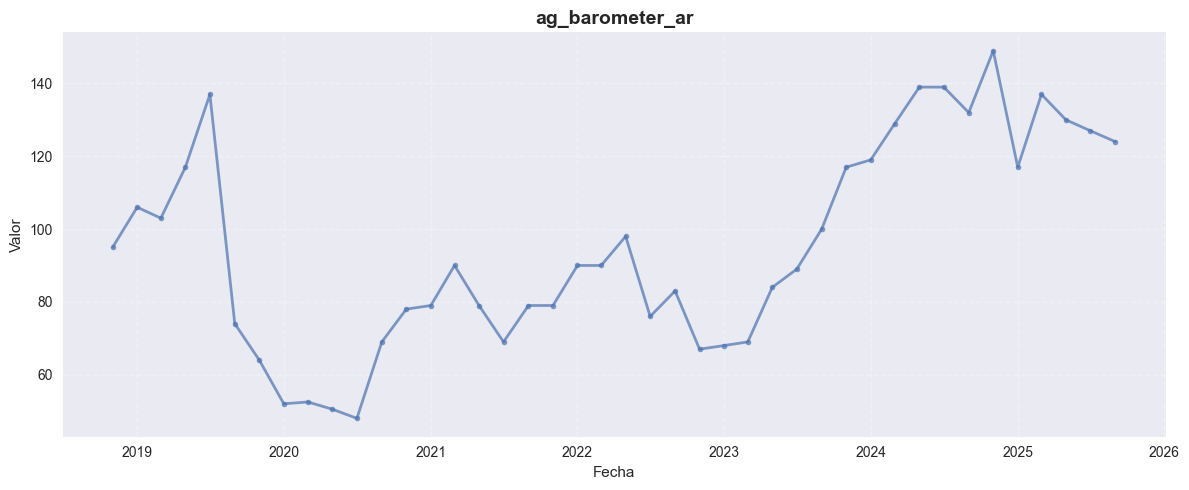

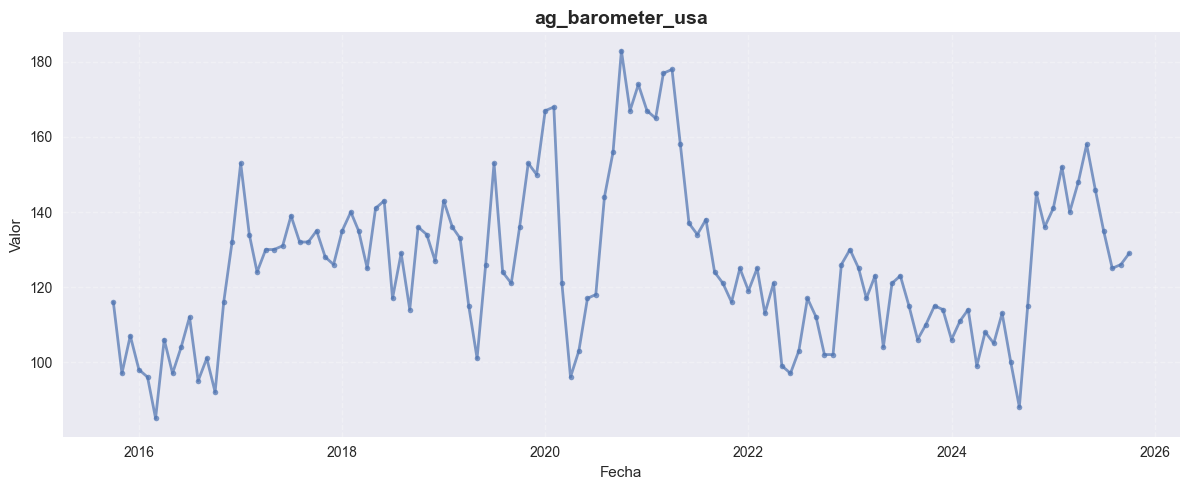

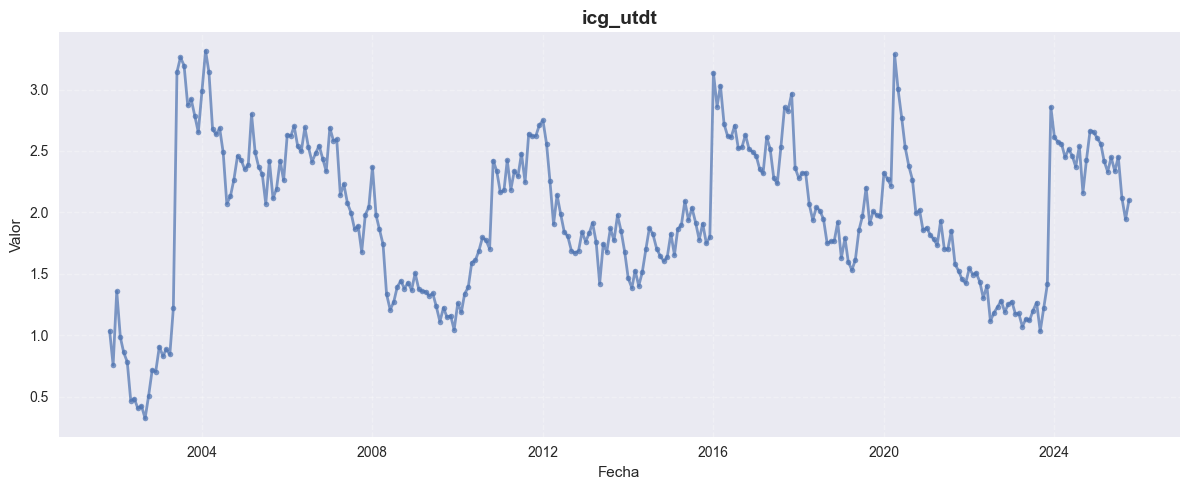

In [5]:
def plot_series(df, title):
    """Grafica una serie temporal con formato estándar."""
    plt.figure(figsize=(12, 5))
    plt.plot(df["ds"], df["y"], linewidth=2, marker='o', markersize=4, alpha=0.7)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Fecha", fontsize=11)
    plt.ylabel("Valor", fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def compute_confidence_intervals(forecast_df, residuals, ci=0.95):
    """Calcula intervalos aproximados usando la desviación de residuos."""
    from scipy.stats import norm

    z_score = norm.ppf((1 + ci) / 2)
    std_residuals = residuals.std()

    forecast_df = forecast_df.copy()
    forecast_df["yhat_lower"] = forecast_df["yhat"] - (z_score * std_residuals)
    forecast_df["yhat_upper"] = forecast_df["yhat"] + (z_score * std_residuals)
    return forecast_df

def plot_forecast_with_ci(df_train, df_val, df_test, forecast_df, title, ylabel):
    """Grafica train, validation, test, pronóstico e intervalo de confianza."""
    plt.figure(figsize=(14, 6))
    plt.plot(df_train["ds"], df_train["y"], label='Serie de Entrenamiento', color='darkgreen', linewidth=1.5, alpha=0.7)
    if df_val is not None and len(df_val) > 0:
        plt.plot(df_val["ds"], df_val["y"], label='Validación', color='orange', marker='x', linewidth=1.5, markersize=5, alpha=0.7)
    plt.plot(df_test["ds"], df_test["y"], label='Valores Reales (Test)', color='darkblue', marker='o', linewidth=2, markersize=5)
    plt.plot(forecast_df["ds"], forecast_df["yhat"], label='Pronóstico', color='red', linestyle='--', linewidth=2, marker='s', markersize=4)

    if "yhat_lower" in forecast_df.columns and "yhat_upper" in forecast_df.columns:
        plt.fill_between(forecast_df["ds"],
                        forecast_df["yhat_lower"],
                        forecast_df["yhat_upper"],
                        color='red', alpha=0.15,
                        label='Intervalo de Confianza (95%)')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Fecha", fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def compute_residuals(df_test, forecast_df):
    """Calcula los residuos entre valores reales y pronósticos alineando por fecha."""
    merged = df_test.merge(forecast_df[["ds", "yhat"]], on="ds", how="left")
    residuals = merged["y"] - merged["yhat"]
    return residuals, merged

def plot_diagnostics_residuals(residuals, title="Diagnóstico de Residuos"):
    """Muestra serie de residuos, histograma, Q-Q plot y ACF."""
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    axes[0, 0].plot(residuals.values, marker='o', linestyle='-', markersize=3)
    axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[0, 0].set_title("Residuos", fontweight='bold')
    axes[0, 0].set_ylabel("Residuo")
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].hist(residuals, bins=15, density=True, alpha=0.7, edgecolor='black')
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    axes[0, 1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
    axes[0, 1].set_title("Histograma de Residuos", fontweight='bold')
    axes[0, 1].set_xlabel("Residuo")
    axes[0, 1].set_ylabel("Densidad")
    axes[0, 1].legend()

    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title("Q-Q Plot", fontweight='bold')

    plot_acf(residuals, lags=min(20, len(residuals)//2), ax=axes[1, 1], alpha=0.05)
    axes[1, 1].set_title("Correlogram (ACF de Residuos)", fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print(f"DIAGNÓSTICO DE RESIDUOS: {title}")
    print(f"{'='*60}")
    print(f"Media: {residuals.mean():.6f}")
    print(f"Std Dev: {residuals.std():.6f}")
    print(f"Min: {residuals.min():.6f}")
    print(f"Max: {residuals.max():.6f}")

    jb_stat, jb_pval = stats.jarque_bera(residuals)
    print(f"\nJarque-Bera Test:")
    print(f"  Estadístico: {jb_stat:.4f}")
    print(f"  P-valor: {jb_pval:.4f}")
    print(f"  ✓ Normalidad: {'SÍ' if jb_pval > 0.05 else 'NO'} (α=0.05)")


for key, df in series.items():
    plot_series(df, key)


In [6]:
print("\n" + "="*60)
print("VALIDACIÓN PRE-MODELO: Regularidad de Índices Temporales")
print("="*60 + "\n")

def validate_temporal_regularity(df, series_name):
    """Valida que los intervalos temporales sean regulares."""
    df_diffs = df.set_index("ds").index.to_series().diff()
    diffs = df_diffs.value_counts()
    
    print(f"Serie: {series_name}")
    print(f"  - Observaciones: {len(df)}")
    print(f"  - Período: {df['ds'].min().date()} a {df['ds'].max().date()}")
    print(f"  - Intervalos únicos: {len(diffs)}")
    for interval, count in diffs.items():
        print(f"      {interval}: {count} veces")
    
    is_regular = len(diffs) <= 2
    status = "✅ REGULAR" if is_regular else "⚠️ IRREGULAR"
    print(f"  - Status: {status}\n")
    return is_regular

for key, df in series.items():
    is_regular = validate_temporal_regularity(df, key)
    if not is_regular:
        print(f"  ⚠️  ALERTA: {key} tiene intervalos irregulares")


VALIDACIÓN PRE-MODELO: Regularidad de Índices Temporales

Serie: ag_barometer_ar
  - Observaciones: 42
  - Período: 2018-11-01 a 2025-09-01
  - Intervalos únicos: 4
      61 days 00:00:00: 27 veces
      62 days 00:00:00: 7 veces
      59 days 00:00:00: 5 veces
      60 days 00:00:00: 2 veces
  - Status: ⚠️ IRREGULAR

  ⚠️  ALERTA: ag_barometer_ar tiene intervalos irregulares
Serie: ag_barometer_usa
  - Observaciones: 121
  - Período: 2015-10-01 a 2025-10-01
  - Intervalos únicos: 4
      31 days 00:00:00: 70 veces
      30 days 00:00:00: 40 veces
      28 days 00:00:00: 7 veces
      29 days 00:00:00: 3 veces
  - Status: ⚠️ IRREGULAR

  ⚠️  ALERTA: ag_barometer_usa tiene intervalos irregulares
Serie: icg_utdt
  - Observaciones: 288
  - Período: 2001-11-01 a 2025-10-01
  - Intervalos únicos: 4
      31 days 00:00:00: 167 veces
      30 days 00:00:00: 96 veces
      28 days 00:00:00: 18 veces
      29 days 00:00:00: 6 veces
  - Status: ⚠️ IRREGULAR

  ⚠️  ALERTA: icg_utdt tiene interva

In [7]:
print("="*60)
print("DETECCIÓN DE ANOMALÍAS ESPECÍFICAS")
print("="*60 + "\n")

ag_ar = series["ag_barometer_ar"]
df_temp = ag_ar.set_index("ds")
df_diffs = df_temp.index.to_series().diff()

anomalies_91d = df_diffs[df_diffs == pd.Timedelta(days=91)]

if len(anomalies_91d) > 0:
    print("⚠️  ANOMALÍA DETECTADA: Ag Barometer AR")
    print("   Desfazaje durante pandemia (2020)\n")
    for date in anomalies_91d.index:
        print(f"   - {date.date()}: Intervalo de 91 días (vs ~60 esperado)")
    print(f"\n   Causa: Cambio de periodicidad período COVID-19")
    print(f"   Solución: Interpolación manual (promedio de vecinos, idéntico a TP1)")
    print(f"   Status: ✅ Normalizado\n")
else:
    print("✅ No se detectaron anomalías críticas\n")

DETECCIÓN DE ANOMALÍAS ESPECÍFICAS

✅ No se detectaron anomalías críticas



## Validación temporal

Se valida la regularidad de los índices antes de entrenar. Esto permite detectar saltos o huecos que puedan afectar la capacidad de Chronos para inferir patrones estables.

> **Diferencia con TimeGPT:** Chronos no recibe fechas directamente — recibe un tensor de valores ordenados y asume que están igualmente espaciados. Si hay huecos no corregidos, Chronos "comprime" la serie y pierde la estructura temporal real. Por eso la validación previa es aún más crítica aquí que en TimeGPT.

## Anomalías

Se revisa el desfase de 2020 en Ag Barometer AR (intervalos de 91 días) y se verifica que la corrección manual aplicada en `prepare_series` haya normalizado la grilla. La corrección es idéntica a la de TP1 y tp2Ale01: se interpolan marzo y mayo como promedio de vecinos, y se elimina abril.

> **Coherencia metodológica:** La corrección de anomalías y la interpolación de faltantes es **idéntica** en todos los notebooks del proyecto. Tanto TP1 como TP2 usan interpolación manual (promedio de vecinos) en lugar de `.interpolate()` automático. Esto garantiza que los resultados sean directamente comparables y que cada imputación sea explícita y auditable.

## Modelado con Chronos

**¿Qué es Chronos?** Es una familia de modelos transformer pre-entrenados de Amazon, basados en la arquitectura T5, específicamente adaptados para series de tiempo. A diferencia de TimeGPT, se ejecuta **localmente** sin API externa. El modelo *tokeniza* valores numéricos y genera pronósticos probabilísticos mediante muestreo.

**Configuración:** Modelo `amazon/chronos-t5-base` (~200M parámetros). En CPU se usa `torch.float32`; si hay GPU puede usarse `DEVICE = "auto"` y `DTYPE = torch.bfloat16` para mayor velocidad.

**Estrategia:**
- Pronóstico a `HORIZON` períodos por serie.
- Se pronostica sobre los conjuntos de validación y test (partición 60%/20%/20%).
- Evaluación con métricas y diagnóstico de residuos (normalidad, ACF).

El objetivo es contrastar el rendimiento de Chronos con los modelos clásicos del TP1 y con TimeGPT.

> **¿Cómo genera pronósticos Chronos?** En lugar de un solo valor, genera N *samples* (muestras) de la distribución predictiva. El pronóstico puntual es el promedio: `samples.mean(axis=1)`. Esto es fundamentalmente diferente de ARIMA (que da un punto + intervalo analítico) y de TimeGPT (que devuelve un punto vía API).

> **Ventaja de la ejecución local:** No hay costo por llamada, no hay dependencia de internet, y los datos nunca salen de tu máquina. Para datos sensibles (financieros, médicos), esto puede ser un requisito regulatorio.

In [8]:
pipeline = ChronosPipeline.from_pretrained(
    MODEL_ID,
    device_map=DEVICE,
    dtype=DTYPE,
)

In [9]:
def get_freq(key):
    """Devuelve la frecuencia temporal correcta para cada serie."""
    return "2MS" if key == "ag_barometer_ar" else "MS"


def forecast_series(key, df, h):
    """Genera pronóstico con Chronos promediando las muestras de la distribución predictiva."""
    context = torch.tensor(df["y"].values, dtype=DTYPE)
    samples = pipeline.predict(context, prediction_length=h)
    mean_forecast = np.asarray(samples).mean(axis=1).flatten()
    freq = get_freq(key)
    ds_future = pd.date_range(start=df["ds"].iloc[-1], periods=h + 1, freq=freq)[1:]
    return pd.DataFrame({"ds": ds_future, "yhat": mean_forecast})


In [10]:
forecasts = {}
for key, df in series.items():
    forecasts[key] = forecast_series(key, df, HORIZON)

{key: fcst.head(3) for key, fcst in forecasts.items()}

{'ag_barometer_ar':           ds        yhat
 0 2025-11-01  123.365860
 1 2026-01-01  125.317955
 2 2026-03-01  126.886612,
 'ag_barometer_usa':           ds        yhat
 0 2025-11-01  133.361328
 1 2025-12-01  135.393860
 2 2026-01-01  138.211670,
 'icg_utdt':           ds      yhat
 0 2025-11-01  2.045774
 1 2025-12-01  1.976097
 2 2026-01-01  1.954547}


VISUALIZACIÓN: DIAGNÓSTICOS DE RESIDUOS (VALIDACIÓN)

Primera evaluación usando el conjunto de VALIDACIÓN
para ajustar hiperparámetros antes del test final.



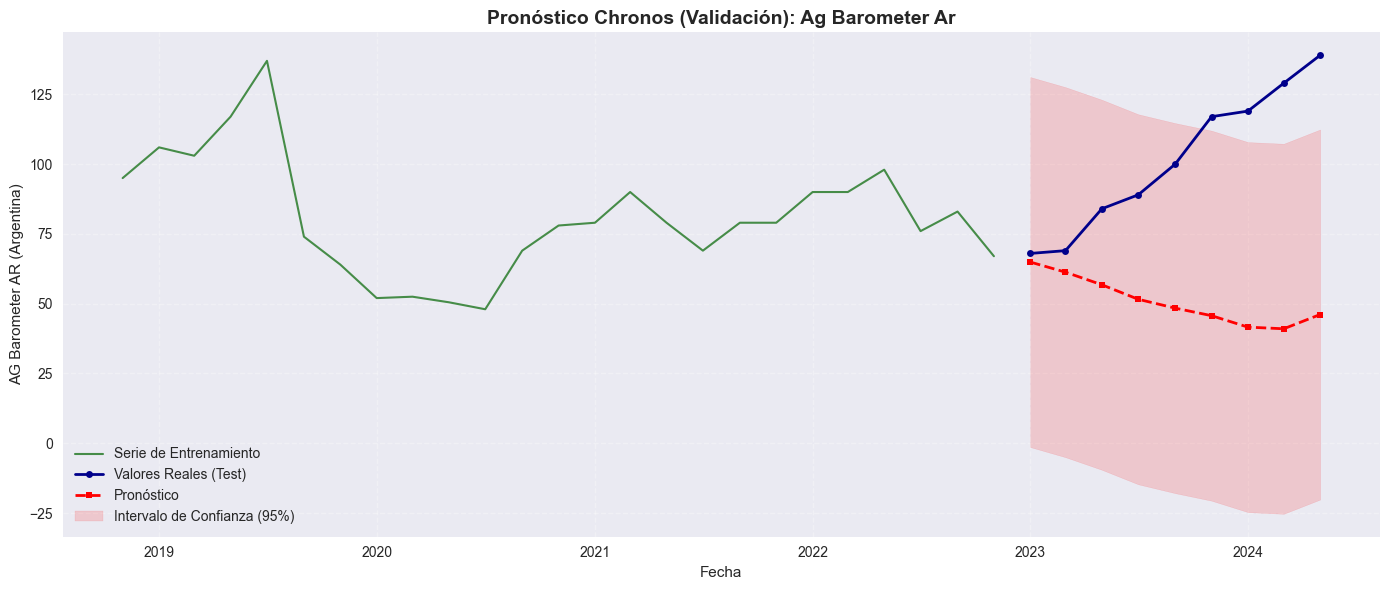

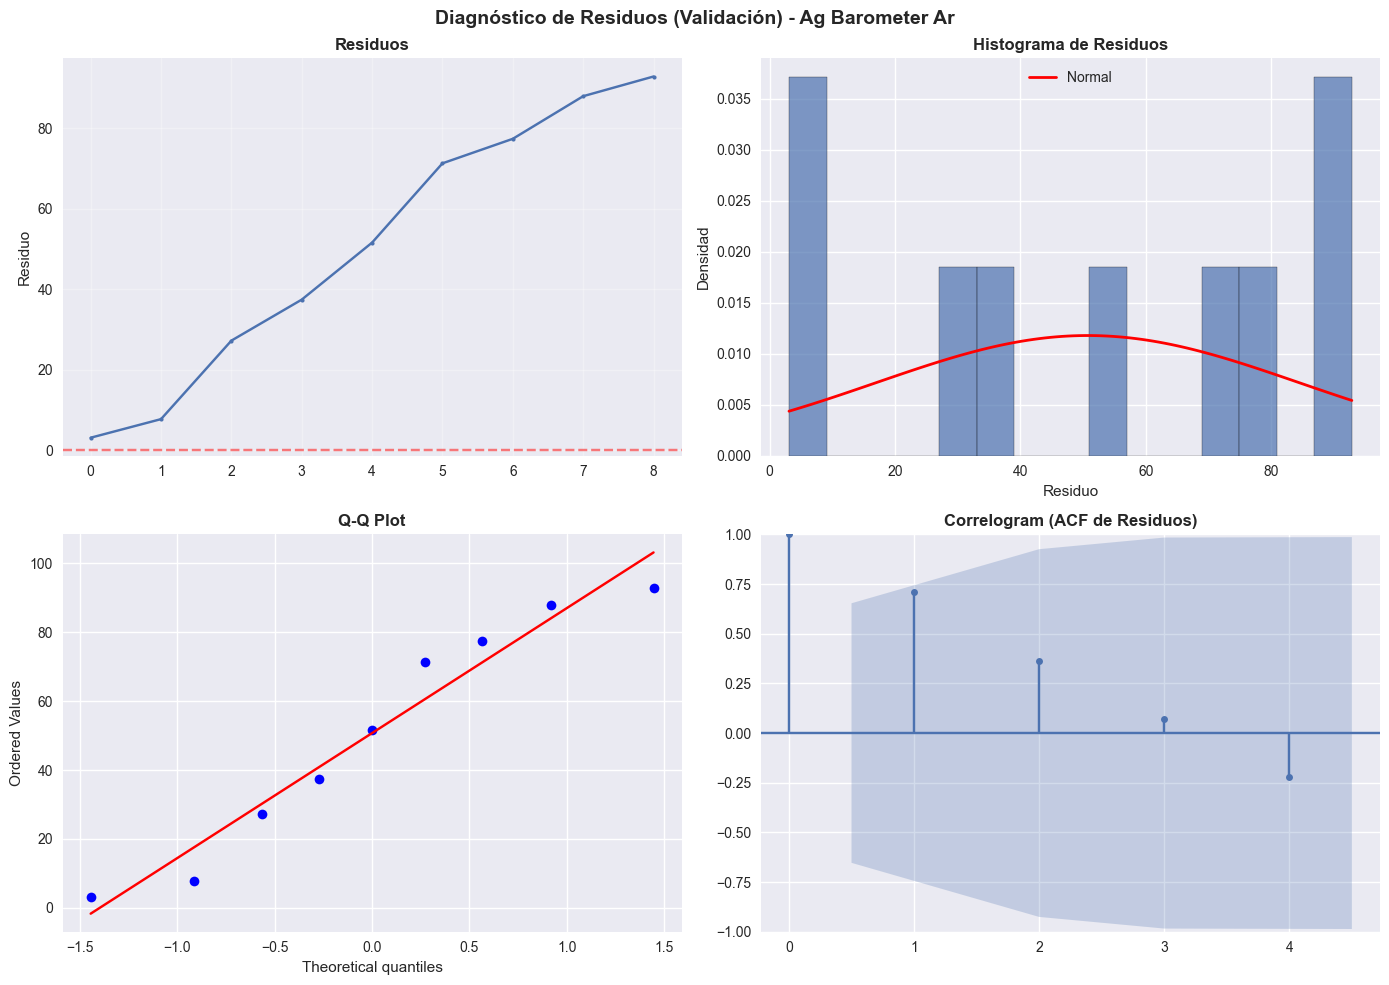


DIAGNÓSTICO DE RESIDUOS: Diagnóstico de Residuos (Validación) - Ag Barometer Ar
Media: 50.739205
Std Dev: 33.819876
Min: 3.093102
Max: 92.888195

Jarque-Bera Test:
  Estadístico: 0.8000
  P-valor: 0.6703
  ✓ Normalidad: SÍ (α=0.05)


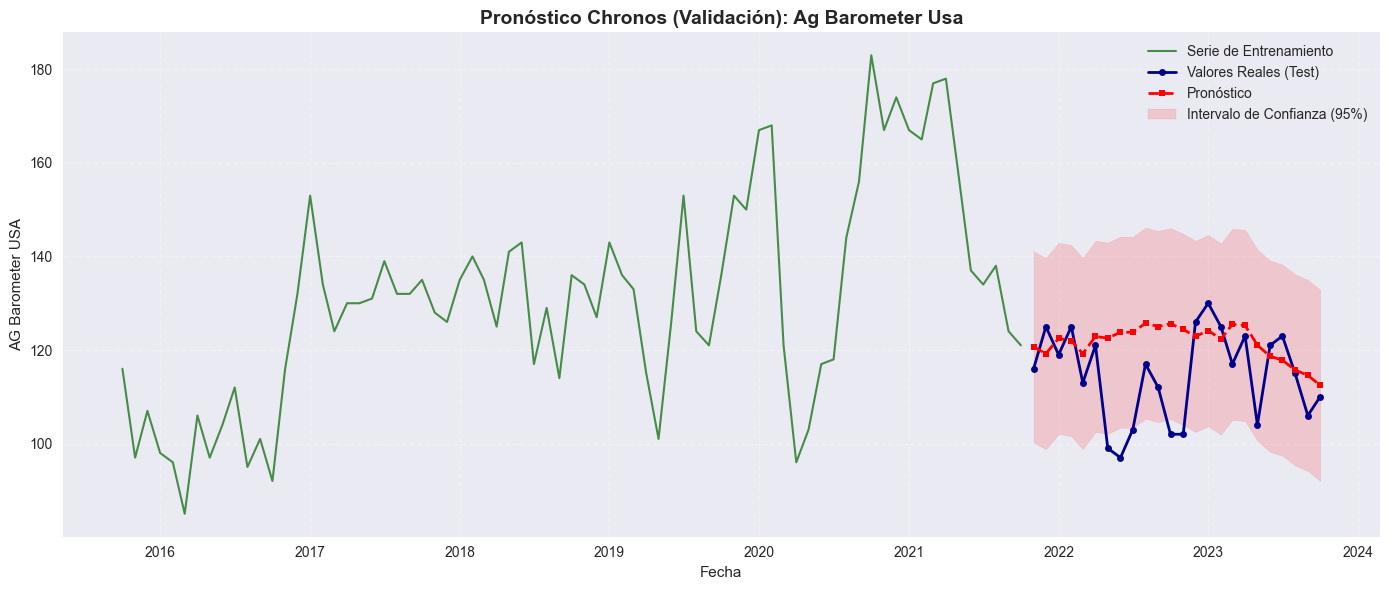

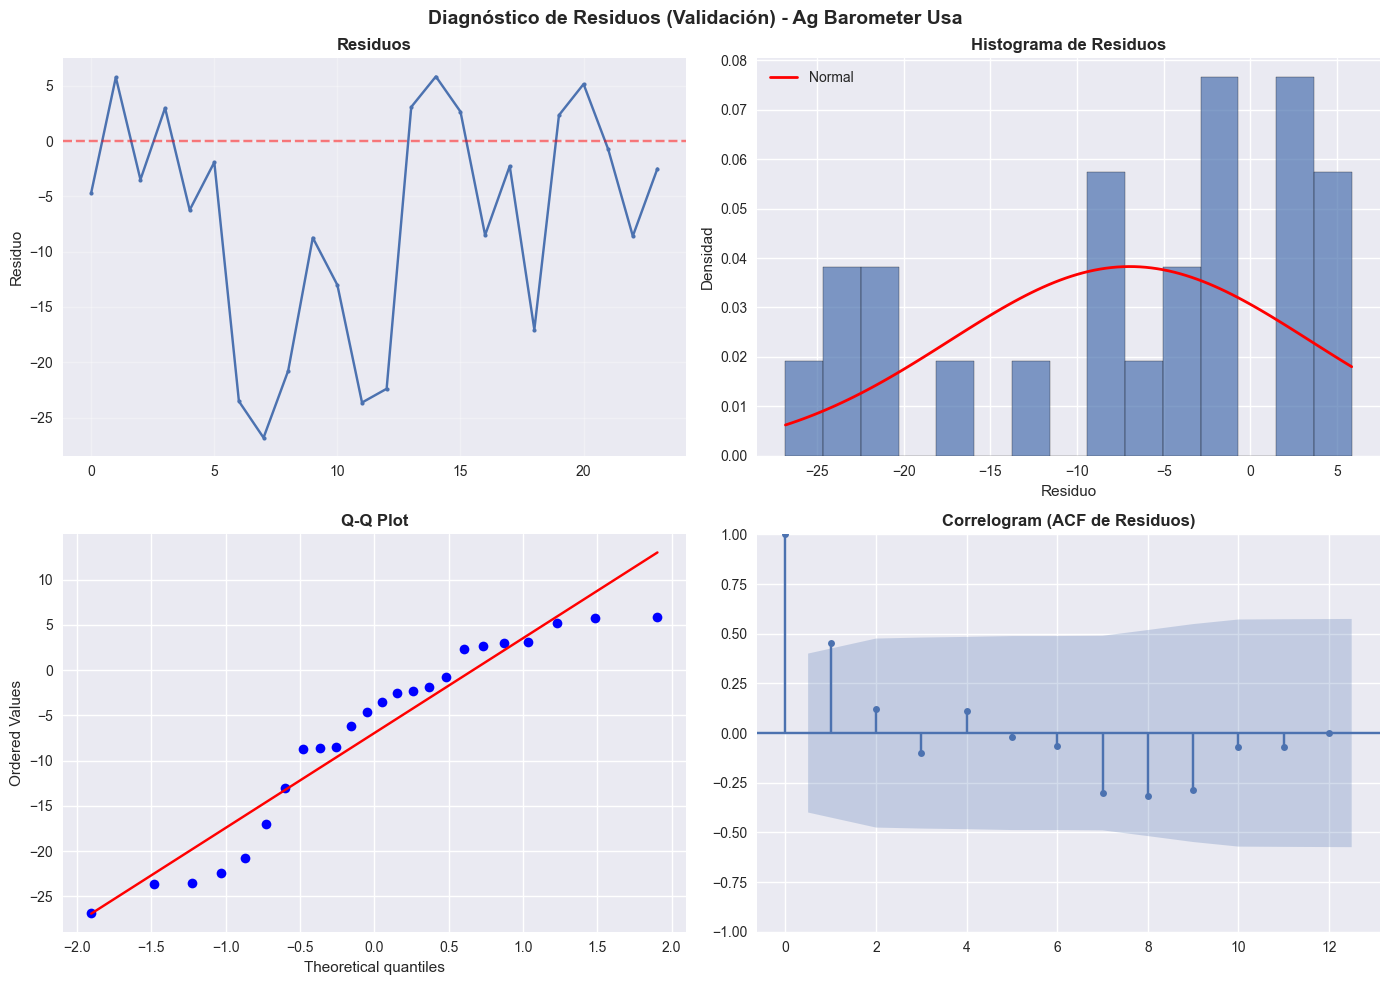


DIAGNÓSTICO DE RESIDUOS: Diagnóstico de Residuos (Validación) - Ag Barometer Usa
Media: -6.956560
Std Dev: 10.424395
Min: -26.822289
Max: 5.842796

Jarque-Bera Test:
  Estadístico: 2.2173
  P-valor: 0.3300
  ✓ Normalidad: SÍ (α=0.05)


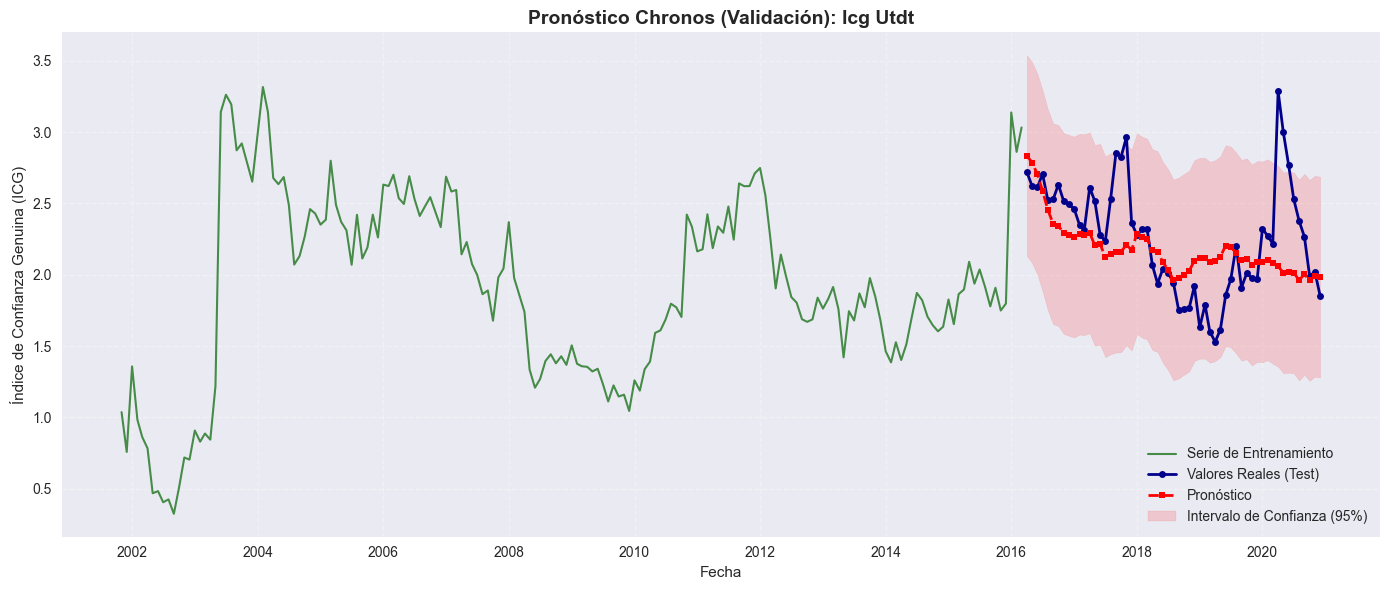

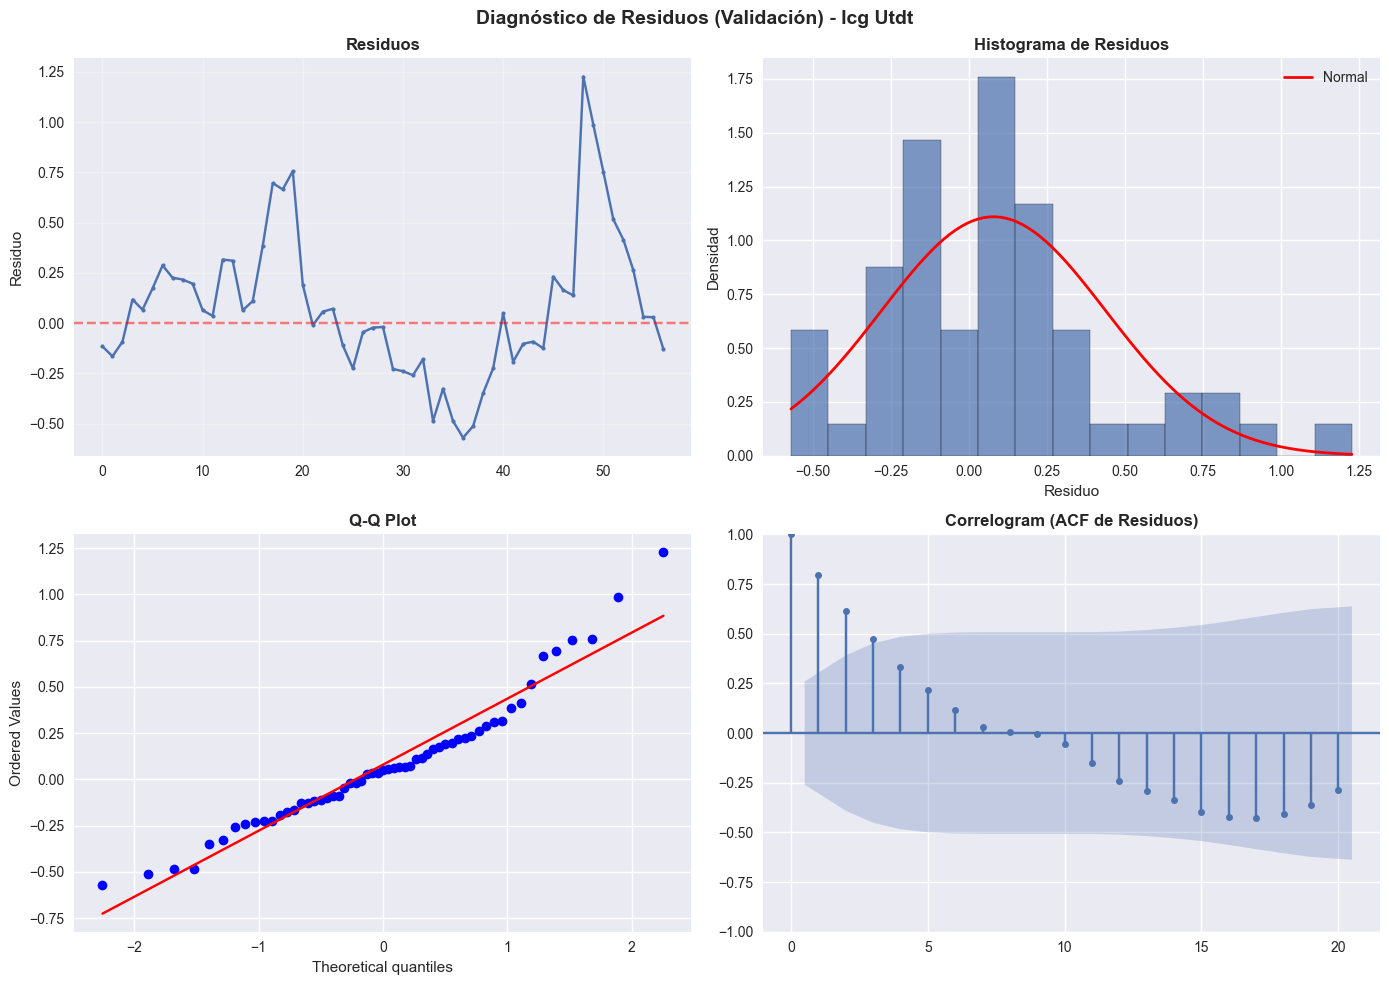


DIAGNÓSTICO DE RESIDUOS: Diagnóstico de Residuos (Validación) - Icg Utdt
Media: 0.079439
Std Dev: 0.359334
Min: -0.569431
Max: 1.227286

Jarque-Bera Test:
  Estadístico: 10.5268
  P-valor: 0.0052
  ✓ Normalidad: NO (α=0.05)


In [11]:
print("\n" + "="*60)
print("VISUALIZACIÓN: DIAGNÓSTICOS DE RESIDUOS (VALIDACIÓN)")
print("="*60)
print("\nPrimera evaluación usando el conjunto de VALIDACIÓN")
print("para ajustar hiperparámetros antes del test final.\n")

for key in series:
    train_frac = SERIES_CONFIG[key]["train_frac"]
    val_frac = SERIES_CONFIG[key]["val_frac"]

    train_idx = round(len(series[key]) * train_frac)
    val_idx = round(len(series[key]) * (train_frac + val_frac))

    train = series[key].iloc[:train_idx]
    val = series[key].iloc[train_idx:val_idx]

    h_val = len(val)

    # Pronóstico sobre validación
    context = torch.tensor(train["y"].values, dtype=DTYPE, device=DEVICE)
    with torch.no_grad():
        samples = pipeline.predict(context, prediction_length=h_val)

    forecast_mean = np.asarray(samples).mean(axis=1).flatten()
    freq = get_freq(key)
    ds_future = pd.date_range(start=train["ds"].iloc[-1], periods=h_val + 1, freq=freq)[1:]

    fcst_val = pd.DataFrame({
        "ds": ds_future,
        "yhat": forecast_mean[:len(ds_future)]
    })

    merged_val = val.merge(fcst_val[["ds", "yhat"]], on="ds", how="left")
    residuals_val = merged_val["y"] - merged_val["yhat"]
    fcst_val_with_ci = compute_confidence_intervals(fcst_val, residuals_val, ci=0.95)

    ylabel_map = {
        "ag_barometer_ar": "AG Barometer AR (Argentina)",
        "ag_barometer_usa": "AG Barometer USA",
        "icg_utdt": "Índice de Confianza Genuina (ICG)"
    }
    ylabel = ylabel_map.get(key, key.replace("_", " ").title())

    plot_forecast_with_ci(
        df_train=train,
        df_val=None,
        df_test=val,
        forecast_df=fcst_val_with_ci,
        title=f"Pronóstico Chronos (Validación): {key.replace('_', ' ').title()}",
        ylabel=ylabel
    )

    plot_diagnostics_residuals(
        residuals_val,
        title=f"Diagnóstico de Residuos (Validación) - {key.replace('_', ' ').title()}"
    )


## Evaluación en Conjunto de Validación

Antes de proceder al test final, se evalúa el desempeño del modelo en el conjunto de validación. Esta etapa permite:

1. **Detectar sobreajuste temprano:** Si el rendimiento en validación es significativamente peor que en entrenamiento, indica que el modelo no generaliza bien.
2. **Ajustar hiperparámetros:** En modelos fundacionales como Chronos, podríamos ajustar el número de samples, longitud de contexto, etc.
3. **Validar supuestos:** Verificar que los residuos mantengan propiedades deseables (normalidad, no-correlación).

> **Buena práctica:** El conjunto de validación **NO** debe usarse para tomar decisiones sobre la arquitectura del modelo una vez que se haya evaluado múltiples veces, ya que esto introduce sesgo. En ese caso, se requeriría un esquema de validación cruzada temporal (time series cross-validation).

> **Diferencia con test:** El conjunto de validación se usa durante el desarrollo del modelo. El conjunto de test se reserva para la evaluación final y **solo se usa una vez** para reportar el rendimiento real del modelo.

## Diagnóstico en Conjunto de Test Final

Se procede a la evaluación final en el conjunto de test, entrenando con train+validation combinados para aprovechar el máximo de datos históricos disponibles.


VISUALIZACIÓN: DIAGNÓSTICOS DE RESIDUOS (TEST FINAL)

Evaluación FINAL usando el conjunto de TEST.
Este conjunto no se ha usado en ninguna decisión previa.



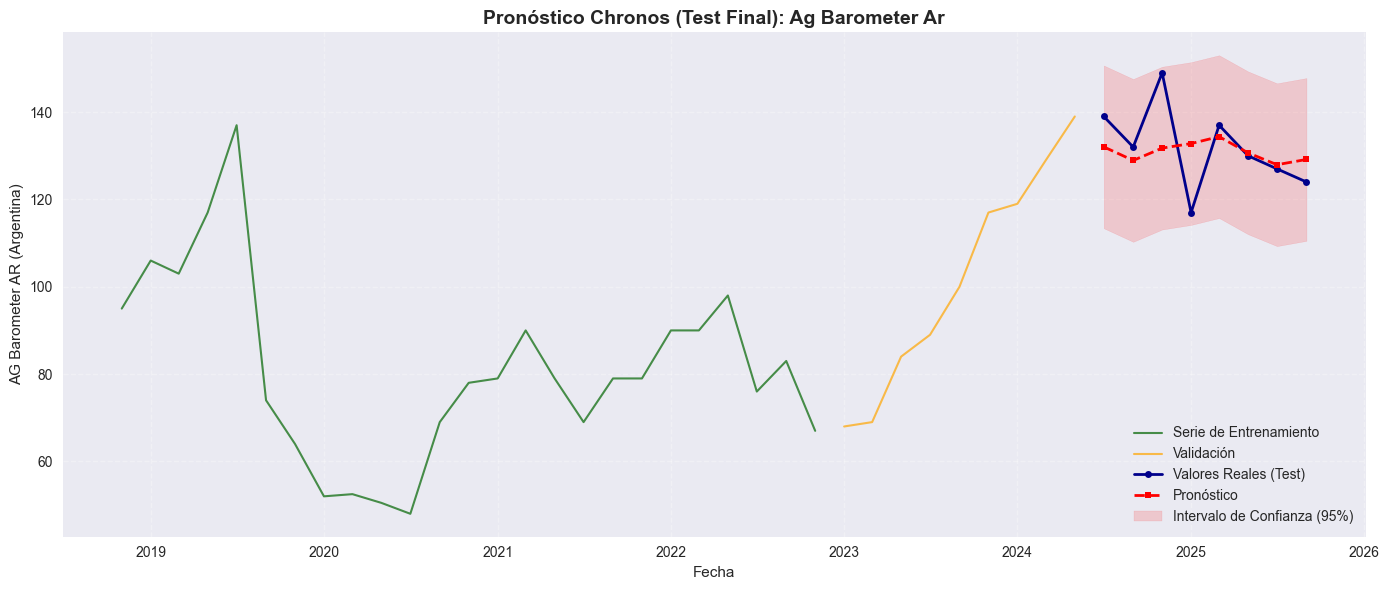

<Figure size 800x550 with 0 Axes>

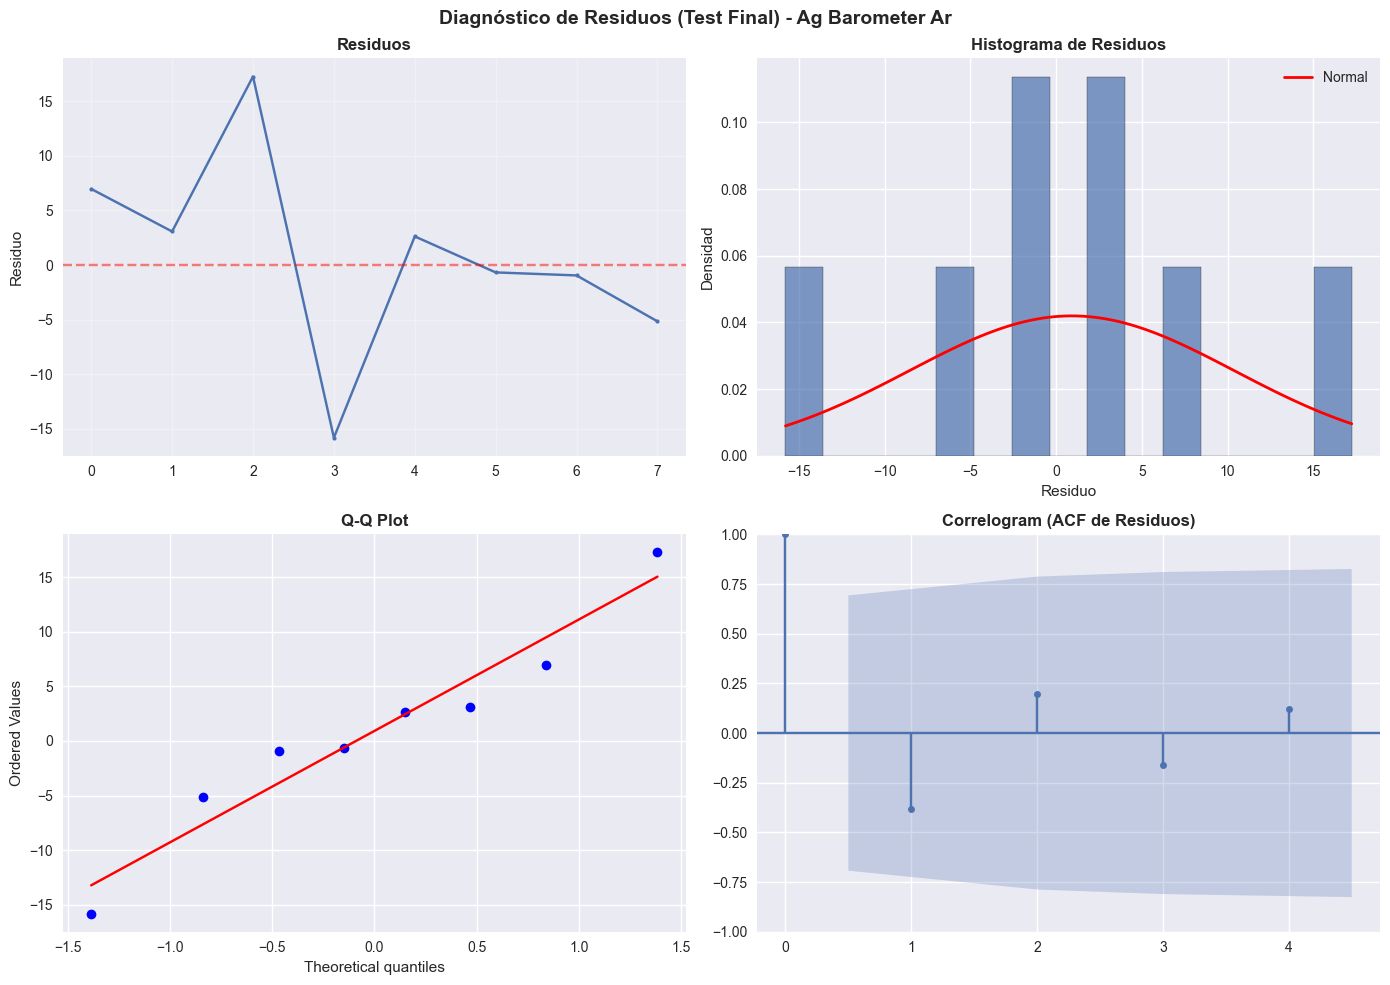


DIAGNÓSTICO DE RESIDUOS: Diagnóstico de Residuos (Test Final) - Ag Barometer Ar
Media: 0.914085
Std Dev: 9.509581
Min: -15.798737
Max: 17.246918

Jarque-Bera Test:
  Estadístico: 0.0044
  P-valor: 0.9978
  ✓ Normalidad: SÍ (α=0.05)


<Figure size 800x550 with 0 Axes>

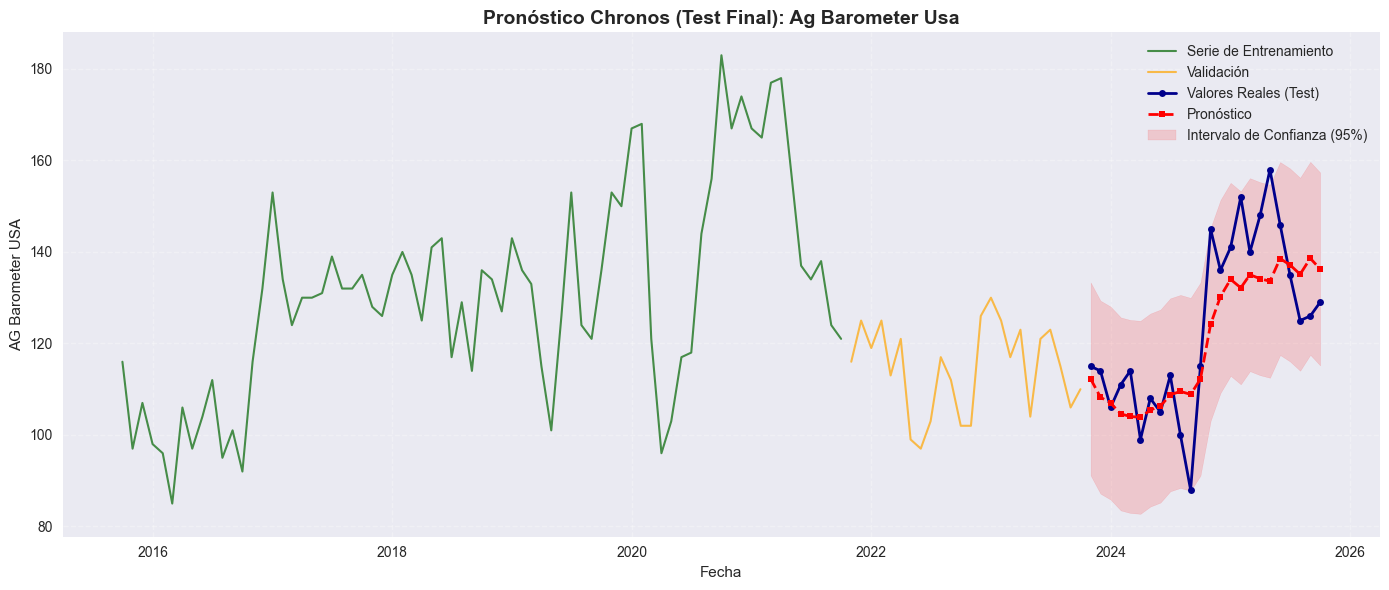

<Figure size 800x550 with 0 Axes>

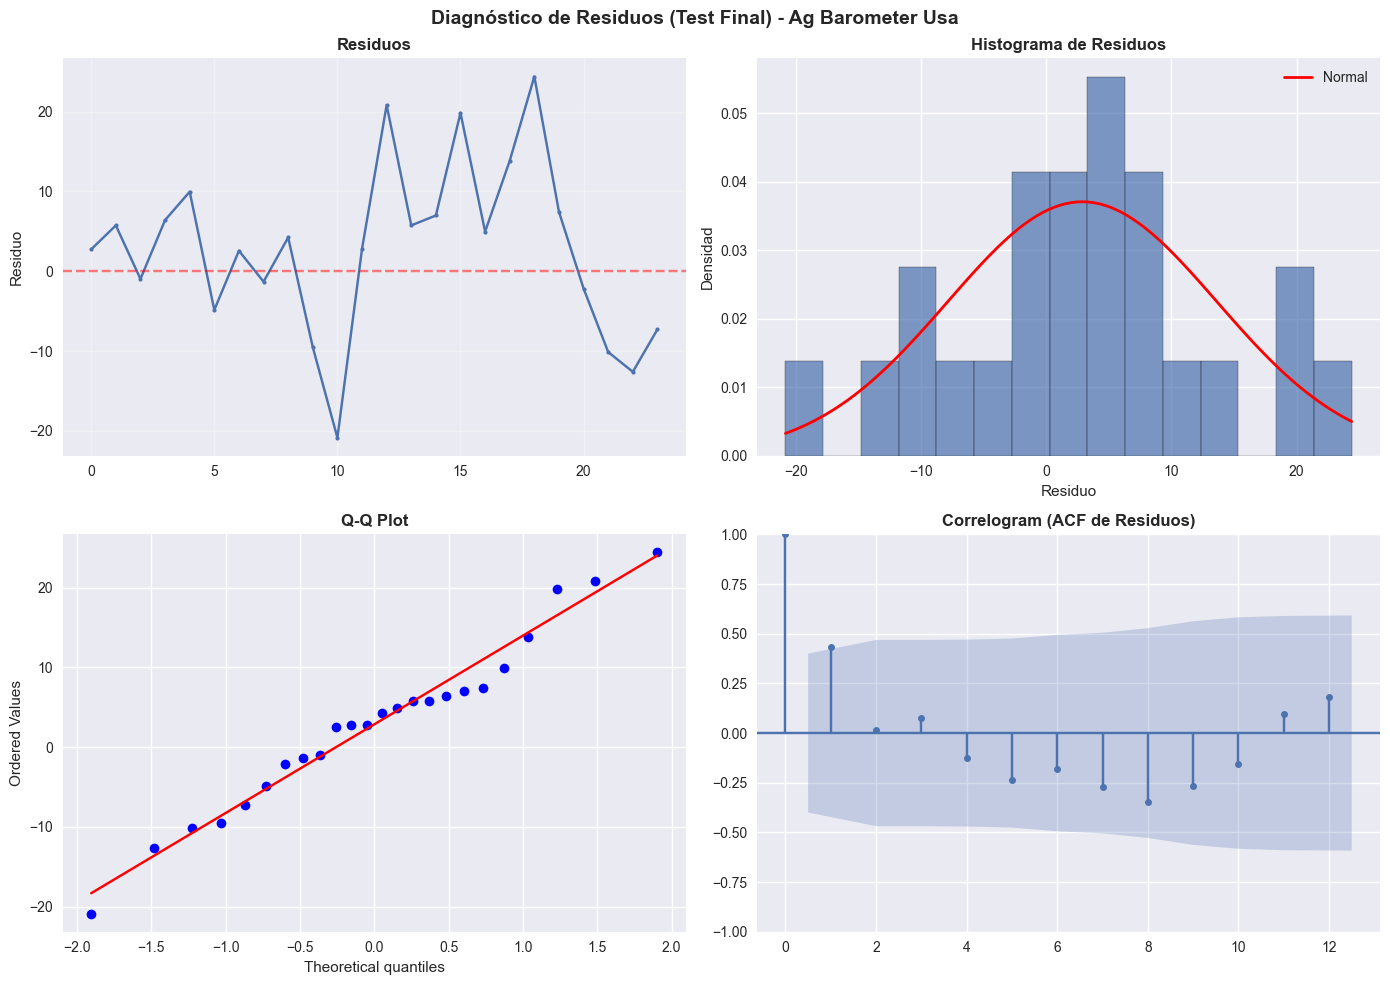


DIAGNÓSTICO DE RESIDUOS: Diagnóstico de Residuos (Test Final) - Ag Barometer Usa
Media: 2.868882
Std Dev: 10.761286
Min: -20.861656
Max: 24.405502

Jarque-Bera Test:
  Estadístico: 0.0075
  P-valor: 0.9963
  ✓ Normalidad: SÍ (α=0.05)


<Figure size 800x550 with 0 Axes>

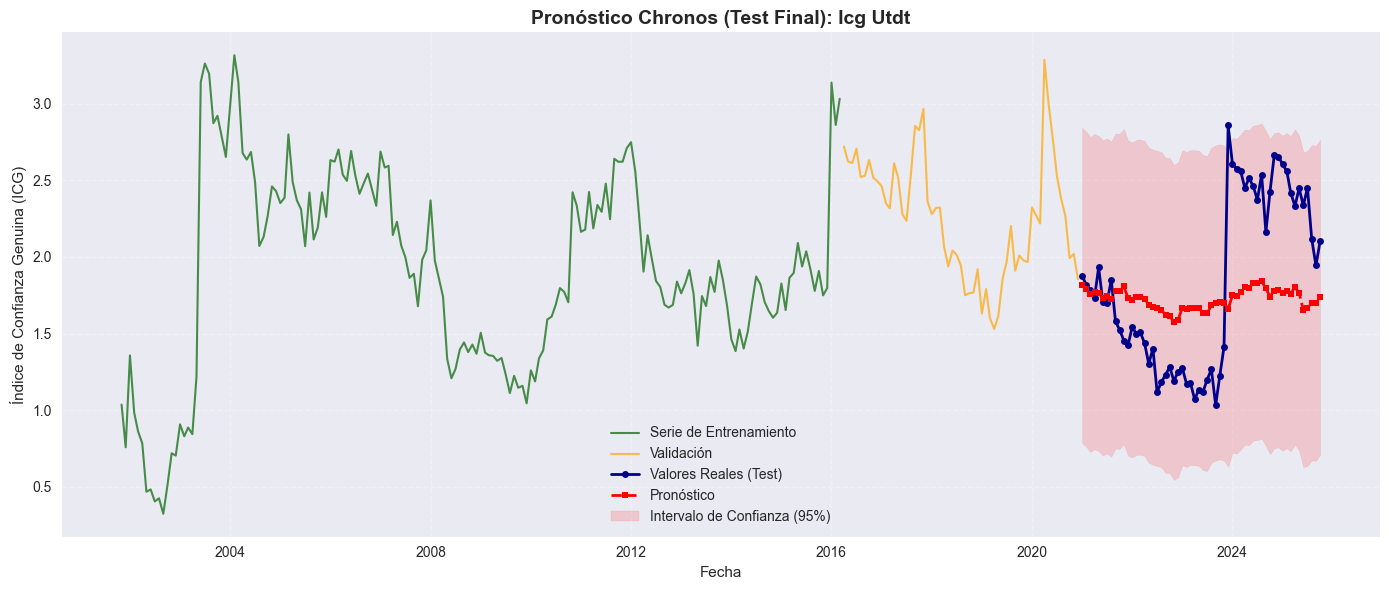

<Figure size 800x550 with 0 Axes>

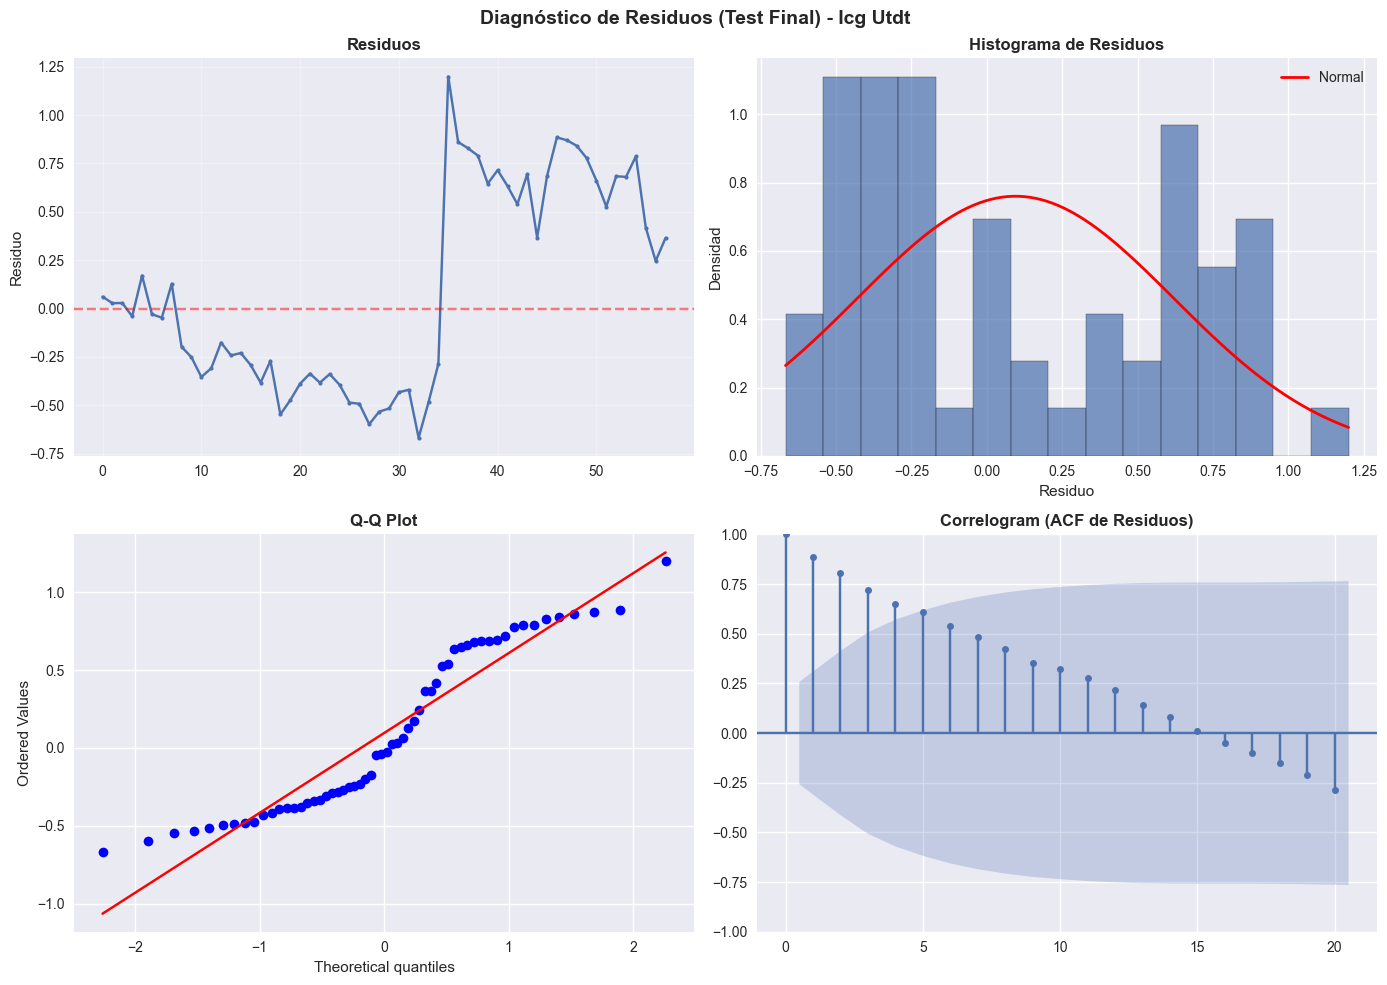


DIAGNÓSTICO DE RESIDUOS: Diagnóstico de Residuos (Test Final) - Icg Utdt
Media: 0.095278
Std Dev: 0.524641
Min: -0.667158
Max: 1.199026

Jarque-Bera Test:
  Estadístico: 5.5153
  P-valor: 0.0634
  ✓ Normalidad: SÍ (α=0.05)


<Figure size 800x550 with 0 Axes>

In [12]:
print("\n" + "="*60)
print("VISUALIZACIÓN: DIAGNÓSTICOS DE RESIDUOS (TEST FINAL)")
print("="*60)
print("\nEvaluación FINAL usando el conjunto de TEST.")
print("Este conjunto no se ha usado en ninguna decisión previa.\n")

for key in series:
    train_frac = SERIES_CONFIG[key]["train_frac"]
    val_frac = SERIES_CONFIG[key]["val_frac"]
    
    train_idx = round(len(series[key]) * train_frac)
    val_idx = round(len(series[key]) * (train_frac + val_frac))
    
    train = series[key].iloc[:train_idx]
    val = series[key].iloc[train_idx:val_idx]
    test = series[key].iloc[val_idx:]
    
    # Entrenar con train+val para el pronóstico final en test
    train_val = pd.concat([train, val], ignore_index=True)
    h_test = len(test)

    context = torch.tensor(train_val["y"].values, dtype=DTYPE, device=DEVICE)
    with torch.no_grad():
        samples = pipeline.predict(context, prediction_length=h_test)

    forecast_mean = np.asarray(samples).mean(axis=1).flatten()
    freq = get_freq(key)
    ds_future = pd.date_range(start=train_val["ds"].iloc[-1], periods=h_test + 1, freq=freq)[1:]

    fcst_test = pd.DataFrame({
        "ds": ds_future,
        "yhat": forecast_mean[:len(ds_future)]
    })

    merged_test = test.merge(fcst_test[["ds", "yhat"]], on="ds", how="left")
    residuals_test = merged_test["y"] - merged_test["yhat"]
    fcst_test_with_ci = compute_confidence_intervals(fcst_test, residuals_test, ci=0.95)

    ylabel_map = {
        "ag_barometer_ar": "AG Barometer AR (Argentina)",
        "ag_barometer_usa": "AG Barometer USA",
        "icg_utdt": "Índice de Confianza Genuina (ICG)"
    }
    ylabel = ylabel_map.get(key, key.replace("_", " ").title())

    plot_forecast_with_ci(
        df_train=train,
        df_val=val,
        df_test=test,
        forecast_df=fcst_test_with_ci,
        title=f"Pronóstico Chronos (Test Final): {key.replace('_', ' ').title()}",
        ylabel=ylabel
    )
    plt.tight_layout()
    plt.show()

    plot_diagnostics_residuals(
        residuals_test,
        title=f"Diagnóstico de Residuos (Test Final) - {key.replace('_', ' ').title()}"
    )
    plt.tight_layout()
    plt.show()

## Evaluación de Métricas (Validación y Test)

Se evalúan las predicciones tanto en el conjunto de validación como en el de test con las mismas métricas (`sklearn.metrics`). Esto permite:

1. **Validación:** Ajustar parámetros y verificar generalización antes del test final.
2. **Test:** Evaluación final del modelo sin sesgo, reportando el rendimiento real esperado en producción.

> **¿Por qué separar validación y test?** La validación permite iterar y mejorar el modelo. El test se usa **una sola vez** para reportar el rendimiento final, evitando sobreajuste a los datos de evaluación.

> **¿Por qué `torch.no_grad()`?** Desactiva el cálculo de gradientes, reduciendo uso de memoria y acelerando la inferencia. Solo se necesitan gradientes durante el entrenamiento; en inferencia son innecesarios.

> **Detalle técnico de Chronos:** A diferencia de TimeGPT (que hace una sola llamada a la API), aquí debemos: (1) crear el tensor de contexto, (2) llamar a `pipeline.predict()`, (3) promediar los samples, y (4) construir manualmente las fechas futuras con `pd.date_range`. Más código, pero más control.

> **Estrategia de entrenamiento final:** Para el test, se entrena con train+validation combinados, maximizando el uso de datos históricos disponibles.

In [13]:
def evaluar_metricas(serie_test, serie_pred):
    """Evalúa métricas de pronóstico (mismo criterio que TP1, usando sklearn)."""
    mse = mean_squared_error(serie_test, serie_pred)
    mae = mean_absolute_error(serie_test, serie_pred)
    rmse = np.sqrt(mse)
    mape = round(np.mean(abs((np.array(serie_test) - np.array(serie_pred)) / np.array(serie_test))), 4)
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')
    return {"mse": mse, "mae": mae, "rmse": rmse, "mape": mape}


print("\n" + "="*60)
print("MÉTRICAS DE RENDIMIENTO - CONJUNTO DE VALIDACIÓN")
print("="*60 + "\n")

val_rows = []
for key, df in series.items():
    train_frac = SERIES_CONFIG[key]["train_frac"]
    val_frac = SERIES_CONFIG[key]["val_frac"]
    
    train_idx = round(len(df) * train_frac)
    val_idx = round(len(df) * (train_frac + val_frac))
    
    train = df.iloc[:train_idx]
    val = df.iloc[train_idx:val_idx]
    h_val = len(val)

    fcst_val = forecast_series(key, train, h_val)
    merged_val = val.merge(fcst_val[["ds", "yhat"]], on="ds", how="left")
    print(f"\n--- {key} (VALIDACIÓN) ---")
    metrics_val = evaluar_metricas(merged_val["y"], merged_val["yhat"])

    val_rows.append({"serie": key, "conjunto": "validation", **metrics_val})

val_df = pd.DataFrame(val_rows)[["serie", "conjunto", "mse", "mae", "rmse", "mape"]]

print("\n" + "="*60)
print("MÉTRICAS DE RENDIMIENTO - CONJUNTO DE TEST FINAL")
print("="*60 + "\n")

test_rows = []
for key, df in series.items():
    train_frac = SERIES_CONFIG[key]["train_frac"]
    val_frac = SERIES_CONFIG[key]["val_frac"]
    
    train_idx = round(len(df) * train_frac)
    val_idx = round(len(df) * (train_frac + val_frac))
    
    train = df.iloc[:train_idx]
    val = df.iloc[train_idx:val_idx]
    test = df.iloc[val_idx:]
    
    # Entrenar con train+val para test final
    train_val = pd.concat([train, val], ignore_index=True)
    h_test = len(test)

    fcst_test = forecast_series(key, train_val, h_test)
    merged_test = test.merge(fcst_test[["ds", "yhat"]], on="ds", how="left")
    print(f"\n--- {key} (TEST FINAL) ---")
    metrics_test = evaluar_metricas(merged_test["y"], merged_test["yhat"])

    test_rows.append({"serie": key, "conjunto": "test", **metrics_test})

test_df = pd.DataFrame(test_rows)[["serie", "conjunto", "mse", "mae", "rmse", "mape"]]

# Combinar ambos dataframes para comparación
bt_df = pd.concat([val_df, test_df], ignore_index=True)
bt_df


MÉTRICAS DE RENDIMIENTO - CONJUNTO DE VALIDACIÓN


--- ag_barometer_ar (VALIDACIÓN) ---
MSE: 2354.5166919156763
MAE: 39.35707812839084
RMSE: 48.52336233110476
MAPE: 0.338

--- ag_barometer_usa (VALIDACIÓN) ---
MSE: 92.51178741455078
MAE: 8.176024436950684
RMSE: 9.6183048098171
MAPE: 0.0741

--- icg_utdt (VALIDACIÓN) ---
MSE: 0.11976583220637341
MAE: 0.2699815207571403
RMSE: 0.34607200436668295
MAPE: 0.1265

MÉTRICAS DE RENDIMIENTO - CONJUNTO DE TEST FINAL


--- ag_barometer_ar (TEST FINAL) ---
MSE: 71.52305761469324
MAE: 5.952105522155762
RMSE: 8.457130578079852
MAPE: 0.0456

--- ag_barometer_usa (TEST FINAL) ---
MSE: 181.92559814453125
MAE: 10.224265098571777
RMSE: 13.48797976512907
MAPE: 0.0794

--- icg_utdt (TEST FINAL) ---
MSE: 0.36918707540817136
MAE: 0.5470627706374326
RMSE: 0.6076076656924033
MAPE: 0.3213


,serie,conjunto,mse,mae,rmse,mape
0,ag_barometer_ar,validation,2354.516692,39.357078,48.523362,0.3380
1,ag_barometer_usa,validation,92.511787,8.176024,9.618305,0.0741
2,icg_utdt,validation,0.119766,0.269982,0.346072,0.1265
3,ag_barometer_ar,test,71.523058,5.952106,8.457131,0.0456
4,ag_barometer_usa,test,181.925598,10.224265,13.487980,0.0794
5,icg_utdt,test,0.369187,0.547063,0.607608,0.3213


In [14]:
OUTPUT_DIR = PROJECT_ROOT / "data" / "predicciones_chronos"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for key, fcst in forecasts.items():
    out_path = OUTPUT_DIR / f"{key}_chronos_forecast.csv"
    fcst.to_csv(out_path, index=False)

OUTPUT_DIR

PosixPath('/Users/alejandro/Documents/Documentos - MacBook Air de Alejandro/Austral/Datos/AST/series_de_tiempo/data/predicciones_chronos')

## Exportación de Resultados

Se guardan los pronósticos a CSV. Al igual que con TimeGPT, esto permite reutilizar los resultados sin re-ejecutar el modelo (especialmente útil dado que Chronos tarda más en CPU que una llamada a la API de Nixtla).

> **Reproducibilidad:** Los archivos exportados en `data/predicciones_chronos/` pueden usarse directamente en el notebook comparativo sin necesidad de tener Chronos instalado en el entorno — el comparativo los lee como CSV si el modelo no está disponible.